<a href="https://colab.research.google.com/github/namhkoh/RIDF-Exploration---Dissertation/blob/main/Image_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
### Imports
import os
import re
import math
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from google.colab import drive
from google.colab.patches import cv2_imshow
from skimage import img_as_float
from skimage.measure import compare_mse as mse
from pylab import *

### Image comparaison
import sys
from scipy.linalg import norm
from scipy import sum, average

### Progress bar imports
from tqdm.notebook import tqdm
# from tqdm import tqdm
from time import sleep

### Mounting drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Methods

In [2]:
### Image processing method

# This method puts files into lists and return them as one list with all images in the folder
def loadImages(path):
    image_files = sorted([os.path.join(path,file)
                          for file in os.listdir(path)
                          if file.endswith('.jpg')])
    return image_files

# This method puts files into lists and return them as one list with all images in the folder
def loadVideo(path):
    video_files = sorted([os.path.join(path,file)
                          for file in os.listdir(path)
                          if file.endswith('.mp4')])
    return video_files 

# This method will resize the images given the percentage of the original image
def resizeImage(images,scale):
  resizedList = []
  for i in range(0,len(images)):
    img = images[i]
    scale_percent = scale # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    resizedList.append(resized)
  print('Original Dimenstions :',resizedList[0].shape)
  return resizedList

# Will read images from path_url and output the dimensions
def readImages(training_images):
  images = []
  for i in tqdm(range(len(training_images))):
    images.append(cv2.imread(training_images[i]))
  print('Original Dimenstions :',images[0].shape)
  return images

# Convert images to gray scale and add them to list
def toGrayScale(images):
  gray_imgs = []
  for i in range(0,len(images)):
    gray = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
    gray_imgs.append(gray)
  return gray_imgs

# Calculates the root mean square error (RSME) between two images (OLD function)
def rmsDiff(image_list,goal_image):
  computed_diff = []
  for i in range(0,len(image_list)):
    computed_diff.append(math.sqrt(mse(img_as_float(image_list[i]), img_as_float(goal_image))))
  return computed_diff

# Plot rmsDiff
def plot_rms(dataset,goal_image,is_val = True):
  computed_rms = []
  for i in range(0,len(dataset)):
    computed_rms.append(math.sqrt(mse(img_as_float(dataset[i]), img_as_float(goal_image))))
  if (is_val):
    return plt.plot(computed_rms)
  else:
    return computed_rms

# Compute and plot RIDF 
def plot_ridf(dataset,goal_image,is_val = True):
  computed_img_diff = []
  for i in range(0,len(dataset)):
    computed_img_diff.append(compare_images(dataset[i],goal_image))
  if (is_val):
    return plt.plot(computed_img_diff)
  else:
    return computed_img_diff

def compare_images(img1, img2):
    # normalize to compensate for exposure difference, this may be unnecessary
    # consider disabling it
    img1 = normalize(img1)
    img2 = normalize(img2)
    # calculate the difference and its norms
    diff = img1 - img2  # elementwise for scipy arrays
    m_norm = np.sum(abs(diff))  # Manhattan norm
    #z_norm = norm(diff.ravel(), 0)  # Zero norm
    #return (m_norm, z_norm)
    return m_norm

def compare_image_total(image_list,goal_image):
  computed_diff = []
  for i in range(0,len(image_list)):
    normalized_image_list = normalize(image_list[i])
    normalized_goal_image = normalize(goal_image)
    diff = normalized_image_list - normalized_goal_image
    m_norm = np.sum(abs(diff))
    computed_diff.append(m_norm)
  return computed_diff

def normalize(arr):
    rng = arr.max()-arr.min()
    amin = arr.min()
    return (arr-amin)*255/rng

# Contrast normalization function

# plotting fucntions

# Human sorting functin
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

# Method to extract each frame from video
def getFrames(vid_url,frame_loc):
  video_to_capture = cv2.VideoCapture(loadVideo(vid_url)[0])
  success,image = video_to_capture.read()
  count = 0
  while success:
    success,image = video_to_capture.read()
    print('Read a new frame: ', success)
    cv2.imwrite(frame_loc + "img%d.jpg" % count, image)     # save frame as JPEG file
    count += 1

# # Compute and plot RIDF 
# def plot_ridf(dataset,goal_image,is_val = True):
#   computed_img_diff = []
#   for i in range(0,len(dataset)):
#     computed_img_diff.append(compare_images(dataset[i],goal_image))
#   if (is_val):
#     return plt.plot(computed_img_diff),computed_img_diff
#   else:
#     return plt.plot(computed_img_diff)

# Global variables

In [3]:
### Image path
dataset_url = "gdrive/MyDrive/Dissertation/exp3"

### Video path 
video_url = "gdrive/MyDrive/Dissertation/videodata"

### Frame path
frame_url = "gdrive/MyDrive/Dissertation/frames"

### Training images
train_img = loadImages(dataset_url)

# Image Processing


## Exp3 Dataset - 15 images

In [4]:
# Reading training images
train_path = loadImages(dataset_url)

# Loading images
train = readImages(train_path)

# Resize 'train_imgs' x% of original image
resized_train = resizeImage(train,5)

# Turn resized images to gray scale
train_gray = toGrayScale(resized_train)

# Apply histogram equlization
equ_list = []
for img in train_gray:
  equ_list.append(cv2.equalizeHist(img))


Original Dimenstions : (4608, 3456, 3)
Original Dimenstions : (230, 172, 3)


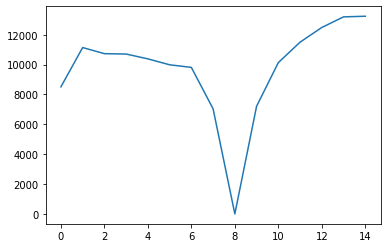

In [5]:
plot_ridf(equ_list,equ_list[8],True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: DEPRECATED: skimage.measure.compare_mse has been moved to skimage.metrics.mean_squared_error. It will be removed from skimage.measure in version 0.18.


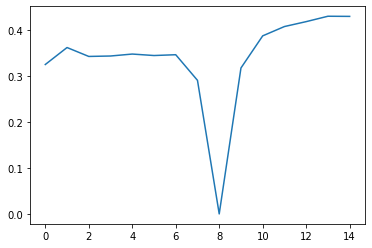

In [6]:
plot_rms(equ_list,equ_list[8],True)

Text(8, 0, 'Goal point')

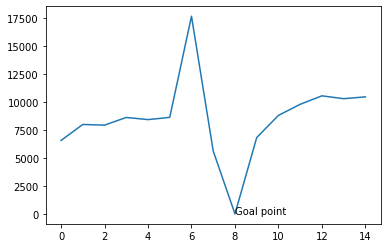

In [7]:
# ABS DIFF
plot_ridf(train_gray,train_gray[8],True)
plt.annotate("Goal point",(8,0))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: DEPRECATED: skimage.measure.compare_mse has been moved to skimage.metrics.mean_squared_error. It will be removed from skimage.measure in version 0.18.


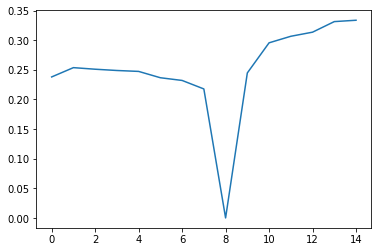

In [8]:
# RMSFalse
plot_rms(train_gray,train_gray[8],True)

## 261 images from video

Images have been taken every 0.030651341 seconds. 
Total video is 8 seconds

In [5]:
# Individual frame paths
train_frames_paths = loadImages(frame_url)

# Human sorting
train_frames_paths.sort(key=natural_keys)

# Loading images
train_frames = readImages(train_frames_paths)

# Resize 'train_imgs' x% of original image
resized_frames = resizeImage(train_frames,15)

# Turn resized images to gray scale
frame_gray = toGrayScale(resized_frames)


Original Dimenstions : (1080, 1920, 3)
Original Dimenstions : (162, 288, 3)


In [6]:
# Apply histogram equlization
frame_eq = []
for img in (frame_gray):
  frame_eq.append(cv2.equalizeHist(img))

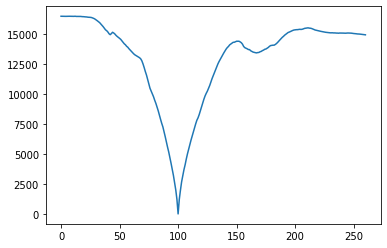

In [11]:
plot_ridf(frame_eq,frame_eq[100],True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: DEPRECATED: skimage.measure.compare_mse has been moved to skimage.metrics.mean_squared_error. It will be removed from skimage.measure in version 0.18.


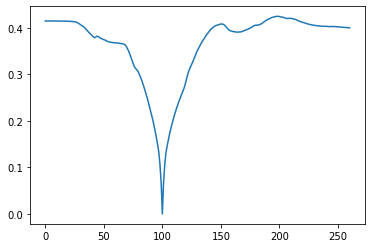

In [12]:
plot_rms(frame_eq,frame_eq[100],True)

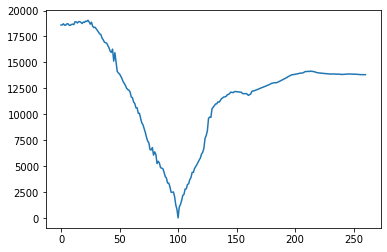

In [13]:
plot_ridf(frame_gray,frame_gray[100],True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: DEPRECATED: skimage.measure.compare_mse has been moved to skimage.metrics.mean_squared_error. It will be removed from skimage.measure in version 0.18.


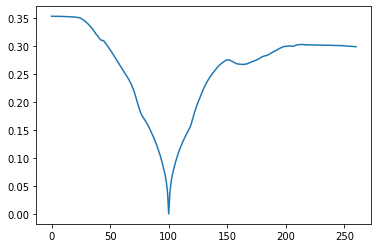

In [14]:
plot_rms(frame_gray,frame_gray[100],True)

## Creating animation for plot.

In [93]:
np_frames = np.array(frame_rms)
np_frames = np_frames.round()
int_frames = []
for frame in np_frames:
  converted = int(frame)
  int_frames.append(converted)

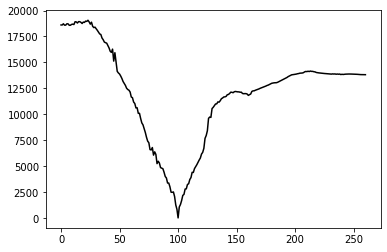

In [95]:
x = int_frames
y = np.arange(0,261,1)

fig, ax = plt.subplots()
line, = ax.plot(y, x, color='k')
plt.show()

def update(num, y, x, line):
    # line.set_data(y[:num], x[:num])
    line.set_xdata(x)
    line.set_ydata(y)
    #line.axes.axis([0, 261, 0, 21393])
    return line,

ani = animation.FuncAnimation(fig, update, x, fargs=[y, x, line],
                              interval=25, blit=True)
# ani.save('test.mp4')
plt.show()

# Calculating Image difference

## Current `snap shot` image from exp3 dataset

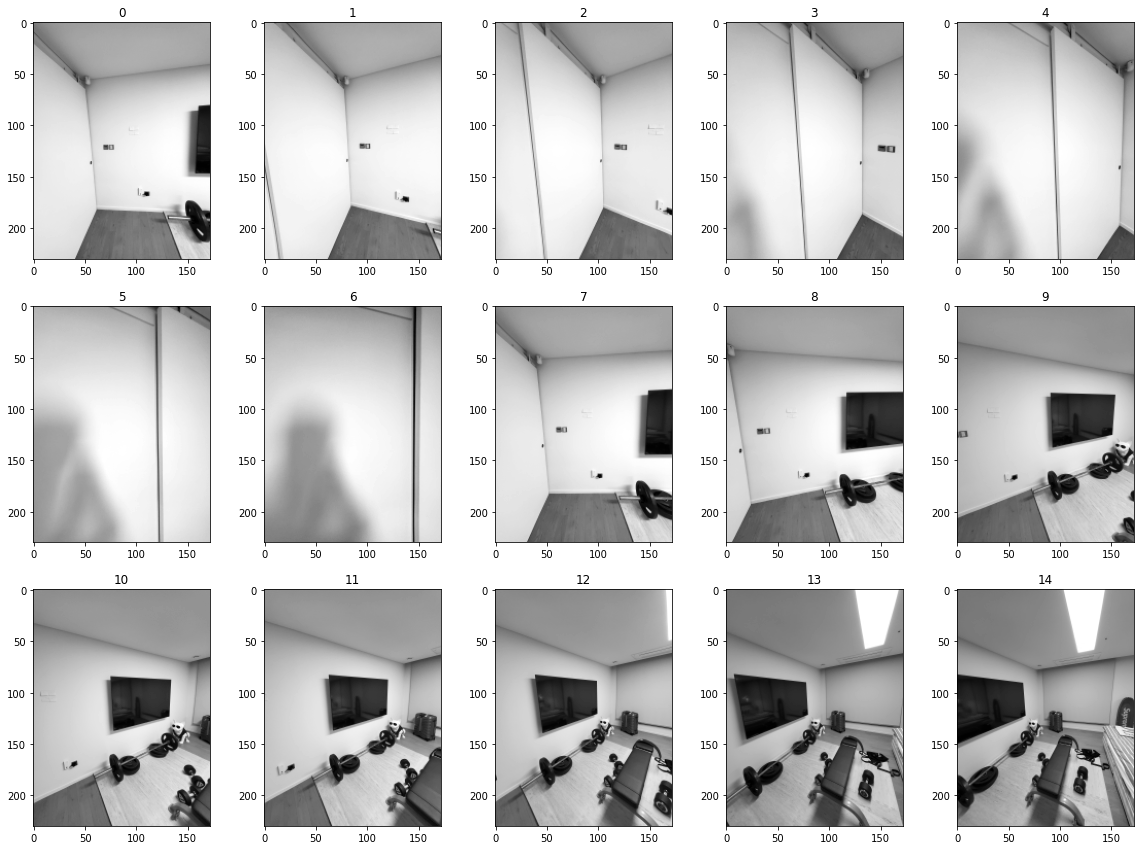

In [15]:
# Plotting all the images as subplots

plt.figure(figsize=(20,20)) # specifying the overall grid size
for i in tqdm(range(0,len(train_gray))):
    plt.subplot(4,5,i+1)    # the number of images in the grid is 5*5 (25)
    plt.title(i)
    plt.imshow(train_gray[i],cmap="gray")
plt.show()

# Comparing the pixel values of the white areas from different images

Do these images register the same white values? 

In [ ]:
# Comparing the matrices values between two images
cv2_imshow(train_gray[3])
cv2_imshow(train_gray[7])
compare_images(train_gray[3],train_gray[8])

In [ ]:
cv2_imshow(train_gray[3])
plt.hist(train_gray[3].ravel(),256,[0,256])
plt.show()

In [ ]:
cv2_imshow(train_gray[7])
plt.hist(train_gray[8].ravel(),256,[0,256])
plt.show()

In [7]:
def show_img_hist(img1,img2):
  fig, axs = plt.subplots(2, 2, figsize=(10,10))

  axs[0, 0].imshow(img1,cmap='gray')
  axs[0, 0].set_title('Image 1')

  axs[0, 1].imshow(img2,cmap='gray')
  axs[0, 1].set_title('Image 2')
  
  axs[1, 0].hist(img1.ravel(),256,[0,256])
  axs[1, 0].set_title('Image 1 - Histogram plot')

  axs[1, 1].hist(img2.ravel(),256,[0,256])
  axs[1, 1].set_title('Image 2 - Histogram plot')

  fig.tight_layout()

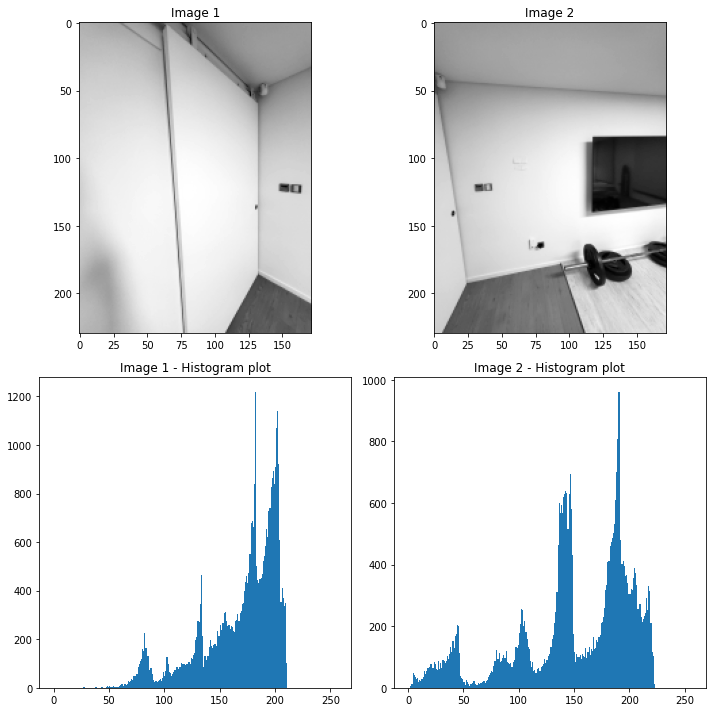

In [8]:
show_img_hist(train_gray[3],train_gray[8])

## Histogram Equalisation

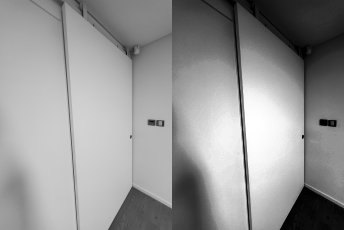

In [17]:
img = train_gray[3]
equ = cv2.equalizeHist(img)
res = np.hstack((img,equ)) #stacking images side-by-side
cv2_imshow(res)

# Complete plot of the `goal image` (snapshot), `Reference image` and `Difference image`

In [16]:
def show_img_hist(img1,img2):
  fig, axs = plt.subplots(2, 2, figsize=(10,10))

  axs[0, 0].imshow(img1,cmap='gray')
  axs[0, 0].set_title('Image 1')

  axs[0, 1].imshow(img2,cmap='gray')
  axs[0, 1].set_title('Image 2')
  
  axs[1, 0].hist(img1.ravel(),256,[0,256])
  axs[1, 0].set_title('Image 1 - Histogram plot')

  axs[1, 1].hist(img2.ravel(),256,[0,256])
  axs[1, 1].set_title('Image 2 - Histogram plot')

  fig.tight_layout()

In [15]:
def ref2Goal(dataset,goal_image,datapoint):
  # use 15,60 for exp3
  # use 40,80 for train_gray
  fig, axs = plt.subplots(len(dataset), 3, figsize=(15,60))
  for i in tqdm(range(0,len(dataset))):
    currentView = dataset[i]
    axs[i][0].imshow(goal_image,cmap='gray')
    axs[i][0].set_title('Goal image')

    axs[i][1].imshow(currentView,cmap='gray')
    axs[i][1].set_title('Current view')

    axs[i][2].plot(datapoint)
    axs[i][2].annotate('Current point', xy=(i, datapoint[i]),  xycoords='data',
            xytext=(0.8, 0.95), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05,width = 0.2),
            horizontalalignment='right', verticalalignment='top')
    axs[i][2].set_title('RIDF Plot')
  fig.tight_layout()
  plt.show()

In [14]:
# input = plot_ridf(frame_gray,frame_gray[100],False)
# ref2Goal(frame_gray,frame_gray[100],input)

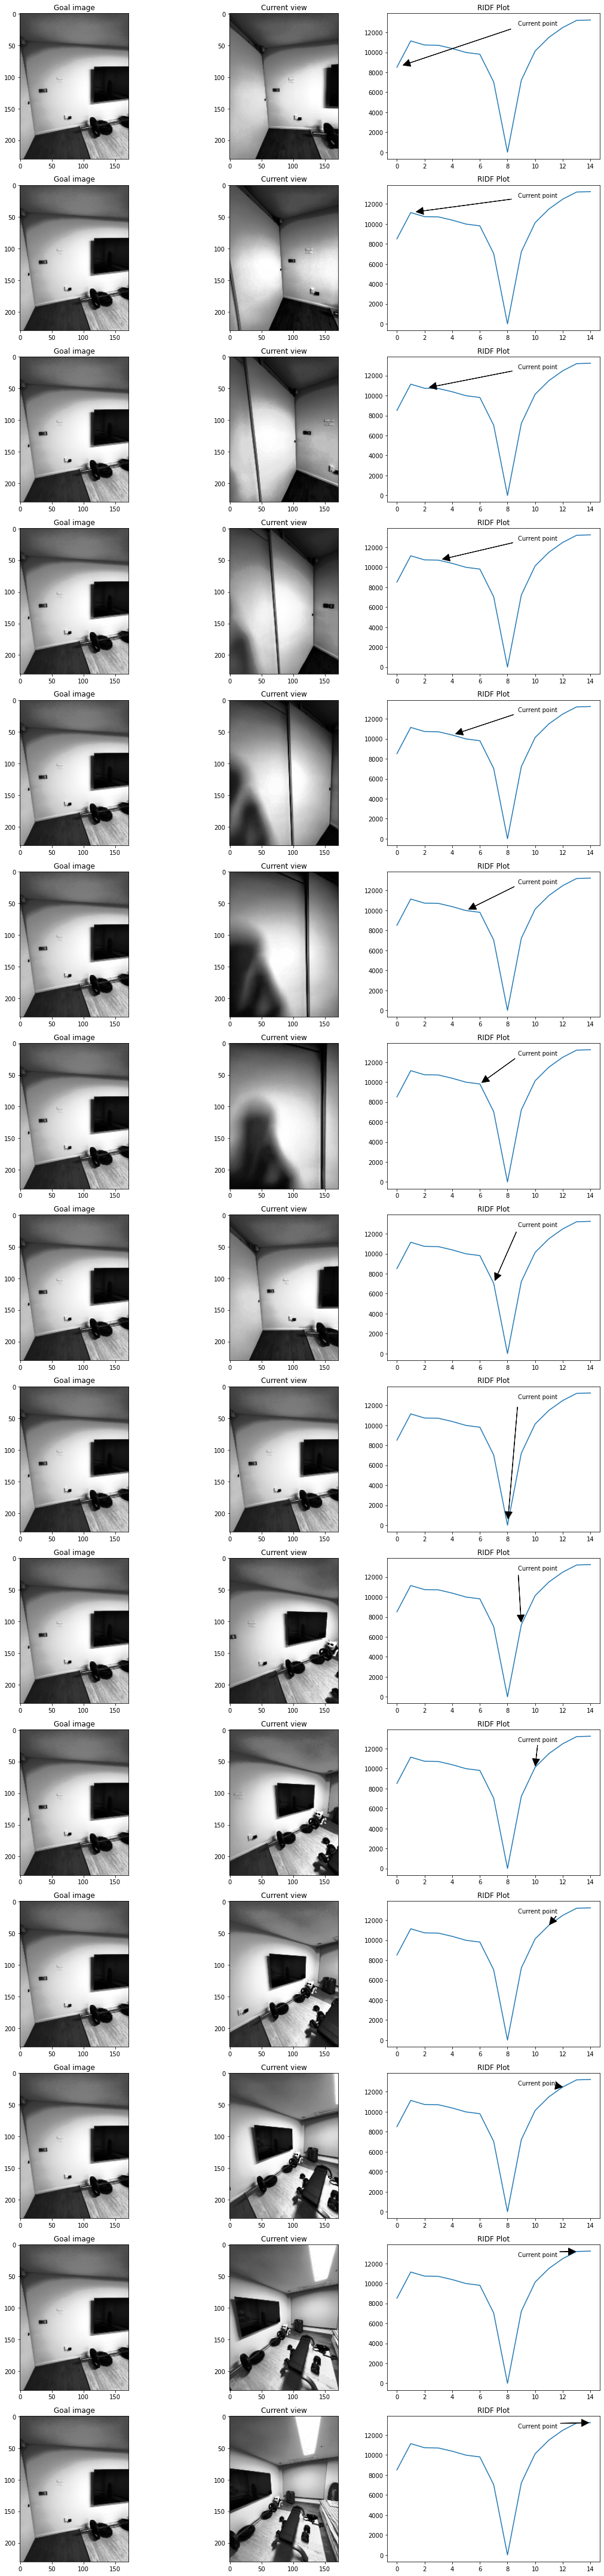

In [17]:
input = plot_ridf(equ_list,equ_list[8],False)
ref2Goal(equ_list,equ_list[8],input)

7922.10243902439


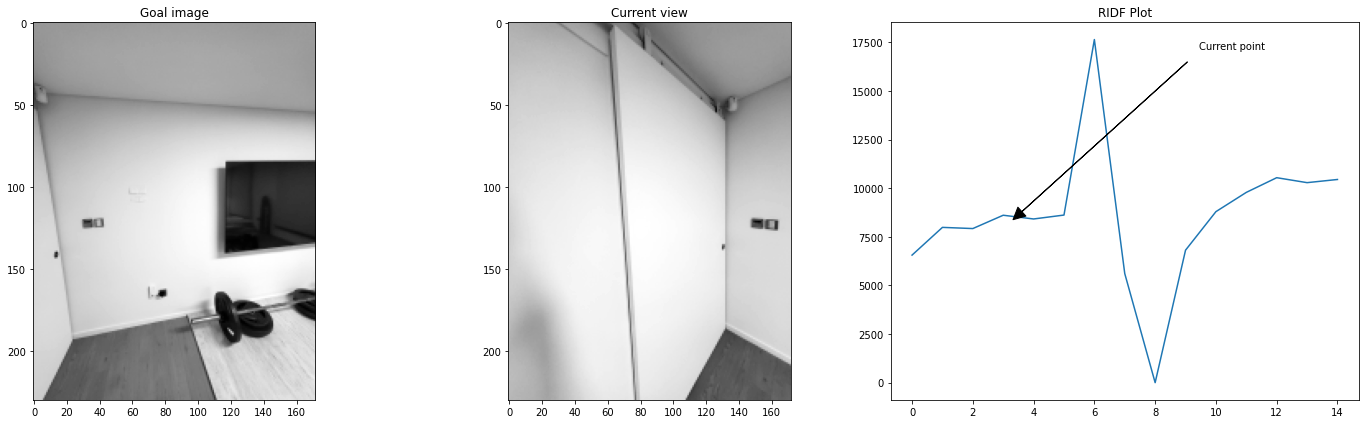

In [385]:
# Dynamically creating rows and columns 
goal_image = train_gray[8]
current_view = train_gray[3]
fig, axs = plt.subplots(1, 3, figsize=(20,6))

axs[0].imshow(goal_image,cmap='gray')
axs[0].set_title('Goal image')

axs[1].imshow(current_view,cmap='gray')
axs[1].set_title('Current view')

axs[2].plot(input)
axs[2].annotate('Current point', xy=(3, input[2]),  xycoords='data',
            xytext=(0.8, 0.95), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05,width = 0.2),
            horizontalalignment='right', verticalalignment='top',
            )
axs[2].set_title('RIDF Plot')
print(input[2])

fig.tight_layout()

# Normalization methods explored

In [ ]:
# Investigate the different contrast normalization functions
# Investigate how the white images compare